In [29]:
import sys, os
from pathlib import Path

# find repo root (parent of "experiments") and add to sys.path
repo_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path(os.getcwd()).parents[0]
sys.path.insert(0, str(repo_root))

from eap_fit_hh.inference import EKFTrainer
from eap_fit_hh.utils import compute_comp_xyz, distance, get_surface_areas, plot_cond_params, update_dict, build_axial_matrix, build_eap_M, compute_eap
from eap_fit_hh.RGC_model import RGC

In [30]:
import jaxley as jx
from jaxley.channels import HH
import matplotlib.pyplot as plt
import matplotlib as mpl

import jax.numpy as jnp
import jax.random as random
import tensorflow_probability.substrates.jax as tfp
tf = tfp.tf2jax
tfd = tfp.distributions

In [31]:
cell = RGC() 

ncomps = cell.shape[1]

In [32]:
pitch = 30  # micrometers
z_plane = -30
x_limits = (-200, 150)
y_limits = (-150, 200)

# Create coordinate arrays
x_coords = jnp.arange(x_limits[0], x_limits[1] + pitch, pitch)
y_coords = jnp.arange(y_limits[0], y_limits[1] + pitch, pitch)
xx, yy = jnp.meshgrid(x_coords, y_coords)
zz = jnp.full_like(xx, z_plane)

# Stack and convert to jnp.array
grid = jnp.stack([xx.ravel(), yy.ravel(), zz.ravel()], axis=-1)
n_points = grid.shape[0]

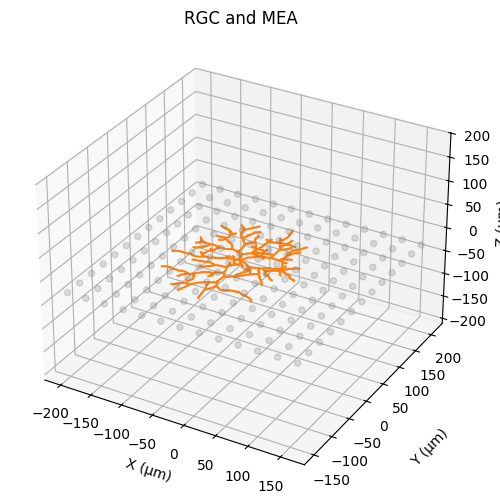

In [33]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot compartments with lines
colors = plt.cm.tab10.colors

# Plot grid points
ax.scatter(grid[:, 0], grid[:, 1], grid[:, 2], c='grey', marker='o', label='Grid Points', alpha=0.25)

cell.vis(ax=ax, color=colors[1],dims =[0,1,2])

# Labels and legend
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)", labelpad=15)
ax.set_zlabel("Z (μm)")
ax.set_title("RGC and MEA")

x_limits = ax.get_xlim()
y_limits = ax.get_ylim()
z_limits = ax.get_zlim()

# Compute the range for each axis
x_range = x_limits[1] - x_limits[0]
y_range = y_limits[1] - y_limits[0]
z_range = z_limits[1] - z_limits[0]

# Find the max range
max_range = max(x_range, y_range, z_range)

# Set new limits so all axes have the same range
x_middle = sum(x_limits) / 2
y_middle = sum(y_limits) / 2
z_middle = sum(z_limits) / 2

ax.set_xlim([x_middle - max_range / 2, x_middle + max_range / 2])
ax.set_ylim([y_middle - max_range / 2, y_middle + max_range / 2])
ax.set_zlim([z_middle - max_range / 2, z_middle + max_range / 2])

plt.show()

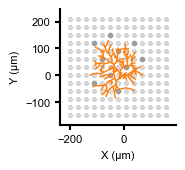

In [34]:
key = random.PRNGKey(0)
N_points = 169  # example total number of points
n_sample = 10   # number of points to sample
#sampled_indices = random.choice(key, jnp.arange(N_points), shape=(n_sample,), replace=False)
sampled_indices = jnp.array([45, 55, 70, 85, 95, 100, 110, 120, 125, 135])

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):
    
    fig, ax = plt.subplots(figsize=(1.5, 1.5))  # no 3D projection

    # Plot grid points in XY only
    ax.scatter(grid[:, 0], grid[:, 1], c='grey', marker='o', label='Grid Points', alpha=0.25)
    ax.scatter(grid[sampled_indices, 0], grid[sampled_indices, 1], c='grey', marker='o', label='Grid Points', alpha=0.6)

    # Plot cell in 2D (XY only) — assumes cell.vis handles dims properly
    cell.vis(ax=ax, color=plt.cm.tab10.colors[1], dims=[0, 1], linewidth=1)  # removed dim=2

    # Labels and legend
    ax.set_xlabel("X (μm)")
    ax.set_ylabel("Y (μm)")

    # Set equal aspect and padding
    ax.set_aspect('equal')
    ax.margins(0.1)

    plt.savefig("rgc_2d.svg")
    plt.show()

In [35]:
true_cell_positions = compute_comp_xyz(cell)
true_distances = distance(grid, true_cell_positions) # in um
true_distances_CM = true_distances * 10**(-4)

In [36]:
true_distances_CM = true_distances_CM[sampled_indices]
true_distances_CM.shape

(10, 122)

In [37]:
dt = 0.025  # ms
t_max = 10.0
times = jnp.arange(0, t_max+2*dt, dt)
n_timesteps = len(times)
current = jx.step_current(i_delay=0.0, i_dur=10., i_amp=.2, delta_t=dt, t_max=t_max)
cell.branch(1).comp(0).stimulate(current)


cell.record("v")
cell.record("HHf_n")
cell.record("HHf_m")
cell.record("HHf_h")

true_outputs = jx.integrate(cell)

Added 1 external_states. See `.externals` for details.
Added 122 recordings. See `.recordings` for details.
Added 122 recordings. See `.recordings` for details.
Added 122 recordings. See `.recordings` for details.
Added 122 recordings. See `.recordings` for details.


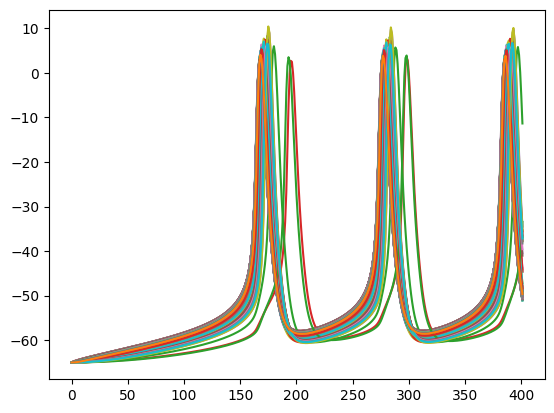

In [38]:
for i in range(ncomps):
    plt.plot(true_outputs[i])

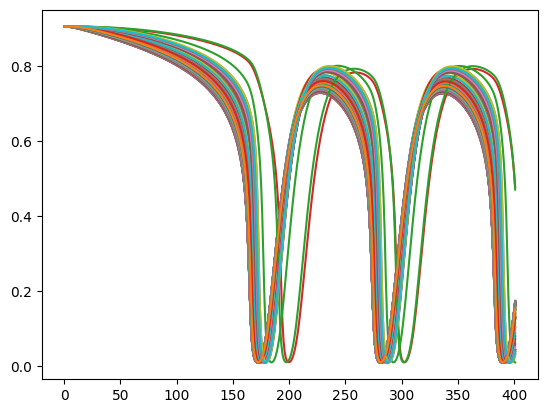

In [39]:
for i in range(ncomps):
    plt.plot(true_outputs[3*ncomps+i])

In [40]:
A = build_axial_matrix(cell)
padded_current = jnp.concatenate([jnp.array([0.]),current])
M = build_eap_M(A, true_distances_CM, 1000)
v = true_outputs[:ncomps]
emissions_EAP = compute_eap(v, M, padded_current, 1, true_distances_CM, 1000) 

In [14]:
M.shape

(10, 122)

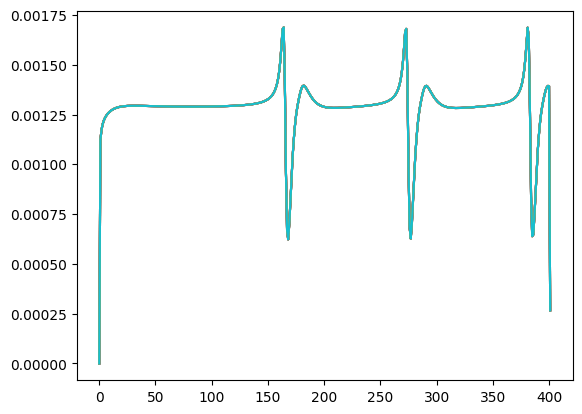

In [45]:
for i in range(len(emissions_EAP)):
    plt.plot(emissions_EAP[70])

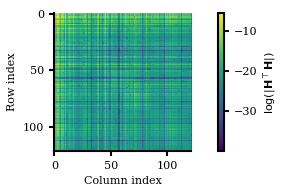

In [105]:
# visualize H.T H

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    plt.figure(figsize=(5.5, 2))
    im = plt.imshow(jnp.log(jnp.abs(M.T@M)), origin='upper', aspect='equal')  # top-left is [0,0]
    cb = plt.colorbar(im)
    cb.set_label(r'$\log(|\mathbf{H}^\top \mathbf{H}|)$')

    # Put ticks at integer indices so it’s obvious which cell is which

    # Draw a box around the top-left (row 0, col 0) cell
    ax = plt.gca()

    # Optional: label that cell

    plt.xlabel('Column index')
    plt.ylabel('Row index')
    plt.tight_layout()
    plt.savefig('RGC_heatmap_10.svg')

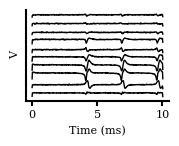

In [106]:
# Choose 10 EAPs
key = random.PRNGKey(0)
N_points = 169  # example total number of points
n_sample = 10   # number of points to sample
sampled_indices = jnp.array([45, 55, 70, 85, 95, 100, 110, 120, 125, 135])
dt = 0.025  # ms
t_max = 10.0
times = jnp.arange(0, t_max+2*dt, dt)
spacing = 0.005  # vertical offset between traces

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    plt.figure(figsize=(5.5/3, 1.5))

    for i, idx in enumerate(sampled_indices):
        trace = emissions_EAP[idx] + i * spacing
        plt.plot(times, trace, color='black', linewidth=1)

    plt.xlabel('Time (ms)')
    plt.ylabel('EAP traces (offset)')
    plt.ylabel("V")
    plt.yticks([])  # hides y-axis ticks
    plt.tight_layout()
    plt.savefig("eap_rgc.svg")

In [107]:
HH_params = ['HHf_gNa', 'HHf_gK', 'HHf_gLeak']
params = {"soma": HH_params, "basal": HH_params}

dynamics_std = {'v': 0.001, 'HHf_m': 0.0001, 'HHf_h': 0.0001, 'HHc_f': 0.0001,
                'i_HHf': 0.01}

Trainer = EKFTrainer(cell = cell,
                     trainable_params = params,
                     dynamics_std = dynamics_std,
                     dt = dt,
                     grid = grid[sampled_indices],
                     extracellular_resistivity = 1000)

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Number of newly added trainable parameters: 1. Total number of trainable parameters: 5
Number of newly added trainable parameters: 1. Total number of trainable parameters: 6
{'soma': ['HHf_gNa', 'HHf_gK', 'HHf_gLeak'], 'basal': ['HHf_gNa', 'HHf_gK', 'HHf_gLeak']}
{'soma': ['HHf_gNa', 'HHf_gK', 'HHf_gLeak'], 'basal': ['HHf_gNa', 'HHf_gK', 'HHf_gLeak']}


In [89]:
bounds = {
    "soma": {
        "HHf_gLeak": (0.0001, 0.005),
        "HHf_gNa": (0.05, 0.1),
        "HHf_gK": (0.01, 0.05),
    },
    "basal": {
        "HHf_gLeak": (0.0001, 0.005), 
        "HHf_gNa": (0.05, 0.1), 
        "HHf_gK": (0.01, 0.05), 
    }
}

init_cond_params = Trainer.sample_cond_params(bounds = bounds, key = 0)

In [90]:
Trainer.position_training = None
Trainer.noise_training    = None
Trainer.smoother = False #only matters if not diagonal

Trainer.diagonal = "diagonal" 
Trainer.obs_std  = 0.0001

loss_fn = Trainer._make_loss(emissions_EAP[sampled_indices].T, current)
loss_val, aux = loss_fn(Trainer.ref_opt_params)
true_mll = - loss_val
print(float(true_mll)) #29246 for stim =.2

8913.084800767634


In [ ]:
def run(lr, init_key):
    init_cond_params = Trainer.sample_cond_params(bounds = bounds, key = init_key)
    out = Trainer.train(data = (emissions_EAP[sampled_indices].T, current),
                init_cond_params = init_cond_params,
                obs_std = 0.0001,
                lr = lr,
                num_epochs = 1000,
                output = ['cond_params'],
                diagonal = True)
    return out

In [86]:
import pickle
with open("RGC_diag10.pkl", "rb") as f: 
    data_diag = pickle.load(f)
    all_out_diag = data_diag["outs"]
    all_mll_diag = all_out_diag["mll"]

In [87]:
all_inferred_params_diag = all_out_diag["cond_params"]

In [115]:
with open("RGC_19_mult10_new_new_new.pkl", "rb") as f: 
    data_bd = pickle.load(f)
    all_out_bd = data_bd["outs"]
    all_mll_bd = all_out_bd["mll"]

In [116]:
all_inferred_params_bd = all_out_bd["cond_params"]

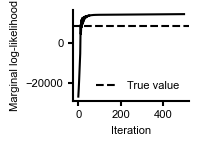

In [144]:
with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    plt.figure(figsize=(5.5/3+0.2, 1.5))
    plt.plot(all_mll_diag[-1], color="black")
    plt.axhline(y=8913, color='black', linestyle='--', label="True value")
    plt.xlabel('Iteration')
    plt.ylabel('Marginal log-likelihood')
    plt.legend()
    plt.tight_layout()
    plt.savefig("mll_rgc_diag_EKF.svg")
    plt.show()

In [117]:
all_mll_bd

Array([[-67133.31996318, -15783.46487007, -15202.43603336, ...,
                    nan,             nan,             nan],
       [-50210.16836904, -80048.0494403 , -75182.3903116 , ...,
                    nan,             nan,             nan],
       [-47536.14320829, -81570.22423274, -73407.31352673, ...,
                    nan,             nan,             nan],
       ...,
       [-74426.44346325, -12275.19226823, -11938.0453316 , ...,
                    nan,             nan,             nan],
       [-45056.82861341, -54700.75547409, -36529.8919806 , ...,
         29351.30544759,  29353.15182381,  29356.36363076],
       [-74569.6484728 ,             nan,             nan, ...,
                    nan,             nan,             nan]],      dtype=float64)

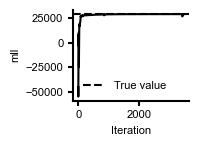

In [156]:
with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    plt.figure(figsize=(5.5/3+0.2, 1.5))
    plt.plot(all_mll_bd[-2], color="black")
    plt.axhline(y=29246., color='black', linestyle='--', label="True value")
    plt.xlabel('Iteration')
    plt.ylabel('mll')
    plt.legend()
    plt.tight_layout()
    plt.savefig("mll_rgc_bd_EKF.svg")
    plt.show()

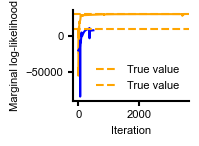

In [155]:
with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    plt.figure(figsize=(5.5/3+0.2, 1.5))
    plt.plot(all_mll_bd[-2], color="orange")
    plt.plot(all_mll_diag[-2], color="blue")
    plt.axhline(y=29246., color='orange', linestyle='--', label="True value")
    plt.axhline(y=8913., color='orange', linestyle='--', label="True value")
    plt.xlabel('Iteration')
    plt.ylabel('Marginal log-likelihood')
    plt.legend()
    plt.tight_layout()
    plt.savefig("mll_rgc_EKF.svg")
    plt.show()

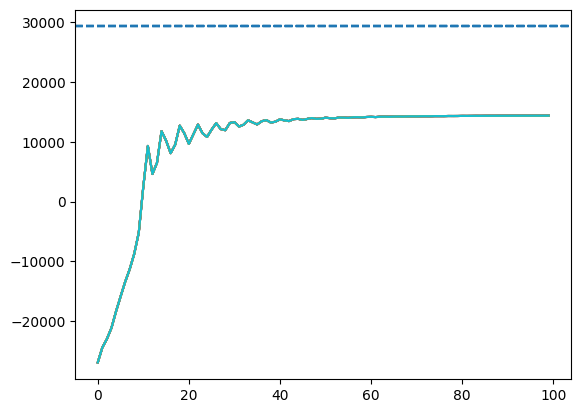

In [103]:
for i in range(10):
    plt.plot(all_mll[-1])
    plt.axhline(29246.069963365295, ls='--') 

In [158]:
all_inferred_params_bd

Array([[-67133.31996318, -15783.46487007, -15202.43603336, ...,
                    nan,             nan,             nan],
       [-50210.16836904, -80048.0494403 , -75182.3903116 , ...,
                    nan,             nan,             nan],
       [-47536.14320829, -81570.22423274, -73407.31352673, ...,
                    nan,             nan,             nan],
       ...,
       [-74426.44346325, -12275.19226823, -11938.0453316 , ...,
                    nan,             nan,             nan],
       [-45056.82861341, -54700.75547409, -36529.8919806 , ...,
         29351.30544759,  29353.15182381,  29356.36363076],
       [-74569.6484728 ,             nan,             nan, ...,
                    nan,             nan,             nan]],      dtype=float64)

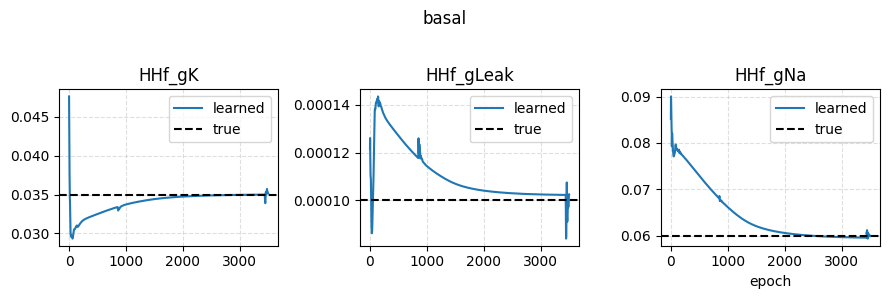

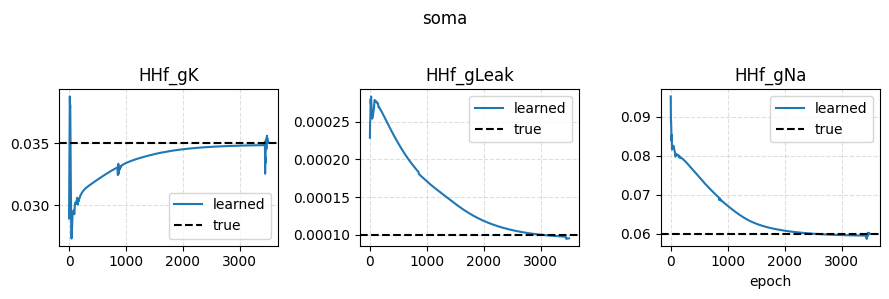

In [162]:
from jax.tree_util import tree_map
idx=-2
inferred_params = tree_map(lambda x: x[idx], all_inferred_params_bd)
plot_cond_params(params = inferred_params, true_params = Trainer.ref_cond_params)

In [119]:
#PLOT TRAJECTORIES
from jax.tree_util import tree_map

comp = 0
idx = -1
selected_idx = jnp.array([idx])
selected_params = tree_map(lambda x: x[selected_idx], all_inferred_params_diag)

all_trajectories_last = []
for idx in selected_idx:
    traj_last = Trainer.integrate_from_params(tree_map(lambda x: x[idx,-1], selected_params))[comp]
    all_trajectories_last.append(traj_last)
    
#init_traj_last = Trainer.integrate_from_params(tree_map(lambda x: x[0,0], selected_params))[comp]

all_trajectories_last_diag = jnp.array(all_trajectories_last)
mean_traj_diag = jnp.mean(all_trajectories_last_diag, axis=0)
std_traj_diag = jnp.std(all_trajectories_last_diag, axis=0)

In [118]:
comp = 0
idx = -2
selected_idx = jnp.array([idx])
selected_params = tree_map(lambda x: x[selected_idx], all_inferred_params_bd)

all_trajectories_last = []
for idx in selected_idx:
    traj_last = Trainer.integrate_from_params(tree_map(lambda x: x[idx,-1], selected_params))[comp]
    all_trajectories_last.append(traj_last)
    
#init_traj_last = Trainer.integrate_from_params(tree_map(lambda x: x[0,0], selected_params))[comp]

all_trajectories_last_bd = jnp.array(all_trajectories_last)
mean_traj_bd = jnp.mean(all_trajectories_last_bd, axis=0)
std_traj_bd = jnp.std(all_trajectories_last_bd, axis=0)

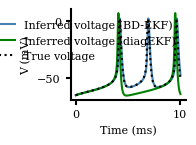

In [124]:
color_low = 'steelblue'
color_high = 'darkorange'

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    plt.figure(figsize=(5.5/3, 1.5))
    plt.plot(times, mean_traj_bd, color=color_low, linestyle='-', label='Inferred voltage (BD-EKF)')
    plt.plot(times, mean_traj_diag, color="green", linestyle='-', label='Inferred voltage (diagEKF)')
    #plt.plot(times, init_traj_last, color="green", label="Initial guess")
    plt.plot(times, true_outputs[comp], color="black", linestyle=':', label="True voltage")
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.legend()
    plt.tight_layout()
    plt.savefig("volt_bdiagEKF_diag_0.svg")

In [168]:
selected_params

{'basal': {'HHf_gK': Array([0.04759231, 0.04621775, 0.04508146, ..., 0.03517475, 0.03515264,
         0.0351324 ], dtype=float32),
  'HHf_gLeak': Array([0.00012147, 0.00012517, 0.00012604, ..., 0.00010258, 0.00010264,
         0.00010253], dtype=float32),
  'HHf_gNa': Array([0.08523926, 0.08772452, 0.09004913, ..., 0.05984978, 0.05987754,
         0.05990184], dtype=float32)},
 'soma': {'HHf_gK': Array([0.02895792, 0.0298268 , 0.03067057, ..., 0.03511645, 0.03510517,
         0.03506099], dtype=float32),
  'HHf_gLeak': Array([2.2861734e-04, 2.3557890e-04, 2.4241376e-04, ..., 9.5416013e-05,
         9.5440220e-05, 9.5454961e-05], dtype=float32),
  'HHf_gNa': Array([0.09527098, 0.09258165, 0.09005149, ..., 0.0599924 , 0.05995604,
         0.05992438], dtype=float32)}}

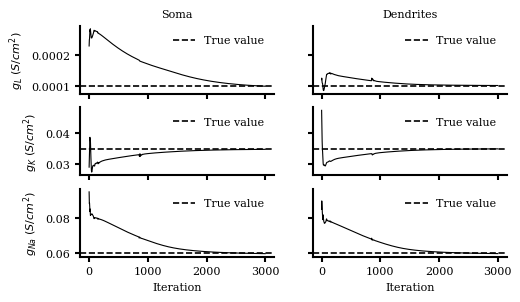

In [176]:
selected_params = tree_map(lambda x: x[-2, :3000], all_inferred_params_bd)

groups = ['soma', 'basal']  # columns = branches
group_name = ['Soma', 'Dendrites']
conductances = [
    ('HH_gLeak', r'$g_L ~(S/cm^2)$'),
    ('HH_gK',    r'$g_K ~(S/cm^2)$'),
    ('HH_gNa',   r'$g_{Na} ~(S/cm^2)$'),
]

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):
    nbranches = len(groups)
    nrows = len(conductances)

    fig, axes = plt.subplots(nrows=nrows, ncols=nbranches, figsize=(5.5, 3),
                              sharex=True, sharey='row')

    colors = plt.cm.coolwarm(jnp.linspace(0, 1, len(selected_idx)))
    num_epochs = 3000
    iterations = jnp.arange(num_epochs)

    # true values: rows = branches, cols = [gL, gK, gNa]
    true_values = jnp.array([
        [0.0001, 0.035,  0.06],
        [0.0001, 0.035,  0.06]
    ])

    # plot traces
    for col, group in enumerate(groups):
        gp_params = selected_params[group]
        traces = [
            gp_params['HHf_gLeak'],
            gp_params['HHf_gK'],
            gp_params['HHf_gNa'],
        ]
        for row, (key, ylab) in enumerate(conductances):
            axes[row, col].plot(iterations, traces[row], linewidth=.8, color="black")

    # decorations: true lines, labels, titles, per-axes legends
    for row, (key, ylab) in enumerate(conductances):
        for col in range(nbranches):
            # dashed true value line WITH label so legend shows in each subplot
            axes[row, col].axhline(y=true_values[col, row], color='black',
                                   linestyle='--', linewidth=1.2, label='True value')
            if row == nrows - 1:
                axes[row, col].set_xlabel('Iteration')

            # per-subplot legend (only the dashed line has a label)
            axes[row, col].legend(loc='upper right', frameon=False, fontsize=8, handlelength=2.0)

        axes[row, 0].set_ylabel(ylab)

    # column titles = branches
    for col in range(nbranches):
        axes[0, col].set_title(group_name[col])


    plt.savefig("rgc_cond_bdiag.svg", bbox_inches='tight')